In [67]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.interpolate import make_interp_spline
import cvxpy as cp

from tqdm import tqdm

In [68]:
def generateData(nTrain, nTest, d, eta=1, sigma_sq_eps=1, wZero=False):
    XTrain = np.diag(np.random.uniform(0,1,nTrain))@np.random.normal(size=(nTrain,d))
    lambsTest = np.diag(np.random.uniform(0,1,nTest))
    XTest = lambsTest@np.random.normal(size=(nTest,d))
    
    if wZero:
        w = np.zeros(d)
    else:
        w = eta*np.random.normal(size=d)/(d**(1/2))
    
    YTrain = XTrain@w + np.sqrt(sigma_sq_eps)*np.random.normal(size=nTrain)
    YTest = XTest@w +  np.sqrt(sigma_sq_eps)*np.random.normal(size=nTest)
    

    return XTrain, YTrain, XTest, YTest, w, lambsTest

In [1]:
### Proximal function for the quantile loss
def qrProx(alpha,c,x):
    return (x > c*(1-alpha))*(x - (1-alpha)*c) + (x < -alpha*c)*(x + alpha*c) 

### Solve the system of equations for quantile regression at the given parameters by brute force
### search over the parameter space
def solveSystem(alpha,gamma,eta=1,sigma_sq_eps=1,gridSize=20,numSamps = 100000):
    Z = np.random.normal(size=numSamps)
    eps = np.sqrt(sigma_sq_eps)*np.random.normal(size=numSamps)
    lambs = np.random.uniform(0,1,numSamps)
    
    beta0s = np.linspace(0.8,12,gridSize)
    cs = np.linspace(14.6,14.9,gridSize)
    norms = np.linspace(2.1,2.3,gridSize)
    
    curMin = float('inf')
    for norm in tqdm(norms):
        for c in cs:
            for beta0 in beta0s:
                ws = eps - beta0 - eta*lambs*norm*Z
                proxes = qrProx(alpha,c*lambs**2,ws) 
                
                eq_1 = gamma*norm**2 - np.mean((ws-proxes)**2/lambs**2)
                eq_2 = gamma - np.mean((ws < c*(1-alpha)*lambs**2) & (ws > c*(-alpha)*lambs**2))
                eq_3 = np.mean((proxes - ws)/(lambs**2))
                
                total = eq_1**2 + eq_2**2 + eq_3**2
                if total < curMin:
                    curMin = total
                    minimizer = (beta0,c,norm)
                    
    return (minimizer, curMin)

### Run quantile regression and return a primal-dual solution pair
def runQR(X,Y,alpha):
    n = len(Y)
    phi = cp.Variable(n)
    
    constraints = [sum(phi) == 0, phi@X == 0, -alpha <= phi, phi <= 1-alpha]
    obj = cp.Maximize(phi@Y)
    prob = cp.Problem(obj,constraints)
    
    prob.solve()
    
    beta0 = constraints[0].dual_value
    beta = constraints[1].dual_value
    
    return (beta0,beta,phi.value)

### Given a solution to the quantile regression system evaluate the true coverage of standard quantile regression
def getCoveragePrediction(beta0,c,norm,sigma_sq_eps,numSamps = 1000000):
    Z = np.random.normal(size = numSamps)
    eps = np.sqrt(sigma_sq_eps)*np.random.normal(size = numSamps)
    lambs = np.random.uniform(0,1,numSamps)
    
    ws = eps - beta0 - lambs*norm*Z
    
    return np.mean(ws <= 0)

### Evaluate the empirical training-conditional coverage of the full quantile regression and 
### standard quantile regression over one draw of the training set. Also evaluate the LOO formula
### for eta_{n+1} and the realized values of the intercept and the l2 error.
def oneQRExperiment(nTrain, nTest, d, eta, sigma_sq_eps, alpha, c):
    XTrain, YTrain, XTest, YTest, betastar, lambsTest = generateData(nTrain, nTest, d, eta, sigma_sq_eps)
    
    ### run standard quantile regression
    (beta0,beta,_) = runQR(XTrain,YTrain,alpha)
    testResid = YTest - beta0 - XTest@beta
    uncorrCov = np.mean(testResid <= 0)
    normGap = np.sqrt(sum((beta-betastar)**2))
    
    ### Use LOO formula to get estimated values of eta_{n+1} (called phi in this code due to naming conflict)
    predictedPhis = (testResid - qrProx(alpha,c*lambsTest**2,testResid))/(c*lambsTest**2)
    
    ### run full conformal
    corrCov = 0
    LOOGap = 0
    for i in range(nTest):
        XFull = np.row_stack((XTrain,XTest[i,:]))
        YFull = np.append(YTrain,YTest[i])
        
        try:
            (_,_,phi) = runQR(XFull,YFull,alpha)
            U = np.random.uniform(-alpha,1-alpha,1)[0]
            corrCov = corrCov + (phi[-1] <= U)/nTest
            LOOGap = LOOGap + np.abs(phi[-1] - predictedPhis[i])[0]/nTest
        except SolverError: 
            print("Solver Error")
        
    return(uncorrCov, corrCov, LOOGap, normGap, beta0)

In [104]:
alpha = 0.1
gamma = 0.3
### Solve the quantile regression system at the specified parameters
solveSystem(alpha,gamma,gridSize=100)

100%|█████████████████████████████████████████████| 100/100 [36:45<00:00, 22.05s/it]


((1.0262626262626262, 14.6, 2.209090909090909), 2.382551330224134e-06)

In [102]:
### Check the intercept and l2 error of the quantile regression fit. Useful for narrowing down the search space
### when looking for solutions to the system of equations
n = 3200
X, Y, _, _, betastar, _ = generateData(n, 1, int(n*gamma))
beta0, beta, _, = runQR(X,Y,alpha)

(beta0, np.sqrt(sum((beta-betastar)**2)))

(1.0148356672740784, 2.161969547641429)

In [72]:
gammas = [0.1,0.2,0.3,0.4,0.5]
### The following solutions to the quantile regression system were computed for the values of gamma above by a combination of 
### searching by hand over the parameter space and leveraging the functions specified above
sols = [
    (1.2263157894736842, 2.3105263157894735, 0.9947368421052633),
    (1.121212121212121, 6.91919191919192, 1.6515151515151516),
    (1.0262626262626262, 14.76842105263158, 2.2473684210526317),
    (0.9736842105263158, 27.178947368421053, 2.9368421052631577),
    (0.9157894736842105, 44.98947368421052, 3.6210526315789475)
]

eta = 1
sigma_sq_eps = 1

nTrials = 1000
nTest = 1
nTrain = 400
alpha = 0.1
numEquationSamps = 1000000

res = pd.DataFrame()
count = 0
for gamma in gammas:
    d = int(gamma*nTrain)
    predCov = getCoveragePrediction(sols[count][0],sols[count][1],sols[count][2],sigma_sq_eps,numEquationSamps)
    
    for i in tqdm(range(nTrials)):
        (uncorrCov, corrCov, LOOGap, normGap, intercept) = oneQRExperiment(nTrain, nTest, d, eta, sigma_sq_eps, alpha, sols[count][1])
        newRes = pd.DataFrame({
            'n' : [nTrain, nTrain],
            'gamma' : [gamma,gamma],
            'Dimension' : [d, d],
            'Method' : ['Uncorrected', 'Full Conformal'],
            'Coverage' : [uncorrCov, corrCov],
            'Predicted Coverage' : [predCov, 1-alpha],
            'LOOGap' : [LOOGap,LOOGap],
            'norm' : [normGap,normGap],
            'intercept' : [intercept, intercept],
            'Predicted Norm' : [sols[count][2],sols[count][2]],
            'Predicted Intercept' : [sols[count][0],sols[count][0]],
            'Predicted c' : [sols[count][1],sols[count][1]]
        })
        res = pd.concat([res,newRes])
    count += 1


100%|███████████████████████████████████████████| 1000/1000 [08:43<00:00,  1.91it/s]


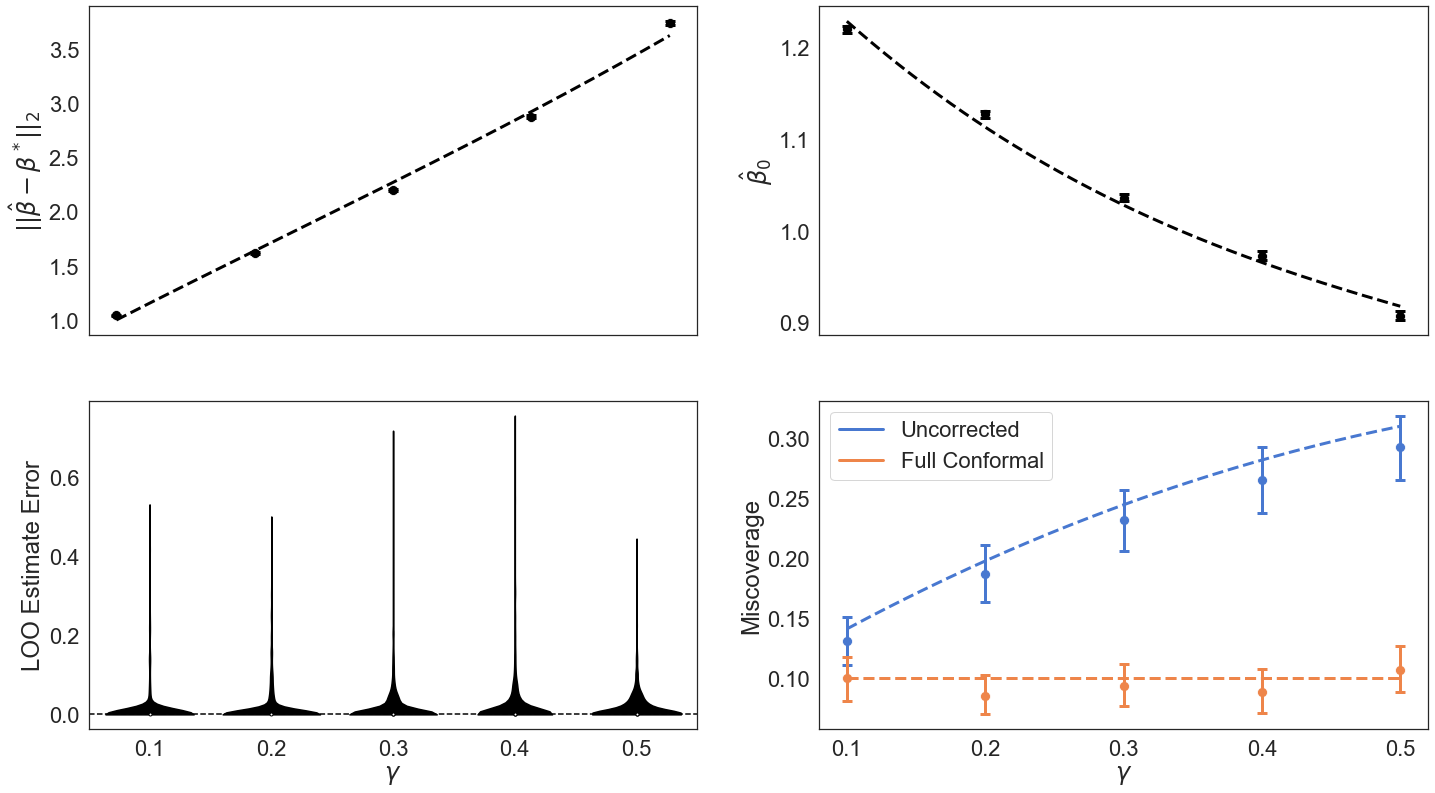

In [135]:
sns.set(rc={'figure.figsize':(24,13.3)})
sns.set(font_scale=2)
sns.set_style(style='white')
fig = plt.figure()

res['Miscoverage'] = 1 - res['Coverage']
gammas = np.array(gammas)

cmap = {}
count = 0
for method in res['Method'].unique():
    cmap[method] = sns.color_palette("muted")[:][count]
    count += 1
    
### Plot norm predictions vs. empirically realized values
ax1 = fig.add_subplot(2,2,1)
f1 = sns.lineplot(
    data=res,
    x='gamma',
    y='norm',
    marker='o',
    linestyle='',
    err_style='bars',
    errorbar=('ci', 95),
    markersize=10,
    color = 'black',
    ax = ax1,
    err_kws={"capsize": 5, "elinewidth": 3, "capthick": 3}
)

g_smooth = np.linspace(gammas.min(), gammas.max(), 300)
preds = [np.mean(res['Predicted Norm'][res['gamma'] == gamma]) for gamma in gammas]
polyfit = np.polyfit(gammas, preds, 3)
y_smooth = np.poly1d(polyfit)(g_smooth)
f1.plot(g_smooth,y_smooth,color = 'black',linewidth=3, linestyle='dashed')

plt.xlabel('')
plt.ylabel('$||\\hat{\\beta} - \\beta^*||_2$')
f1.set(xticklabels=[])

### Plot intercept predictions vs. empirically realized values
ax2 = fig.add_subplot(2,2,2)
f2 = sns.lineplot(
    data=res,
    x='gamma',
    y='intercept',
    marker='o',
    linestyle='',
    err_style='bars',
    errorbar=('ci', 95),
    markersize=10,
    color = 'black',
    ax = ax2,
    err_kws={"capsize": 5, "elinewidth": 3, "capthick": 3}
)

g_smooth = np.linspace(gammas.min(), gammas.max(), 300)
preds = [np.mean(res['Predicted Intercept'][res['gamma'] == gamma]) for gamma in gammas]
polyfit = np.polyfit(gammas, preds, 3)
y_smooth = np.poly1d(polyfit)(g_smooth)
f2.plot(g_smooth,y_smooth,color = 'black',linewidth=3, linestyle='dashed')

plt.xlabel('')
plt.ylabel('$\\hat{\\beta}_0$')
f2.set(xticklabels=[])

### Plot LOO formula errors
ax3 = fig.add_subplot(2,2,3)
f3 = sns.violinplot(
    data=res,
    x='gamma',
    y='LOOGap',
    color = 'black',
    ax = ax3,
    cut = 0
)

f3.axhline(0, color='black',linestyle='dashed')

plt.xlabel('$\\gamma$')
plt.ylabel('LOO Estimate Error')


#### Plot coverage predictions vs. empirically realized values
    
ax4 = fig.add_subplot(2,2,4)
f4 = sns.lineplot(
    data=res,
    x='gamma',
    y='Miscoverage',
    hue='Method',
    marker='o',
    linestyle='',
    err_style='bars',
    errorbar=('ci', 95),
    markersize=10,
    palette = cmap,
    ax = ax4,
    err_kws={"capsize": 5, "elinewidth": 3, "capthick": 3}
)

count = 0
for method in res['Method'].unique():
    g_smooth = np.linspace(gammas.min(), gammas.max(), 300)
    preds = [np.mean(res['Predicted Coverage'][(res['Method'] == method) & (res['gamma'] == gamma)]) for gamma in gammas]
    polyfit = np.polyfit(gammas, preds, 3)
    y_smooth = np.poly1d(polyfit)(g_smooth)
    f4.plot(g_smooth,1-y_smooth,color=sns.color_palette("muted")[:][count],linewidth=3, linestyle='dashed')
    count += 1



plt.xlabel('$\\gamma$')
legend = f4.legend(loc='upper left')
legend.get_lines()[0].set_linewidth(3)
legend.get_lines()[1].set_linewidth(3)

ax4.set_xticks(gammas)

plt.savefig('figures/QR_Validation.pdf')